In [2]:
# Import library

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score


In [11]:
# Load and preprocess data

file_path = '/content/KaggleV2-May-2016.csv'
df = pd.read_csv(file_path)

print(df.info())

# There is no missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


In [35]:
# data cleaning

X = df.drop('No-show', axis=1)
y = df['No-show']

y = [0 if (val == "No") else 1 for val in y]
X['Gender'] = [0 if (val == "M") else 1 for val in X['Gender']]
X['AppointmentDay'] = pd.to_datetime(X['AppointmentDay'])
X['ScheduledDay'] = pd.to_datetime(X['ScheduledDay'])
X['lead-time'] = (X['AppointmentDay'] - X['ScheduledDay']).dt.days


X.drop(['PatientId', 'AppointmentID', 'AppointmentDay', 'ScheduledDay'], axis=1, inplace=True)
y = np.array(y)


In [38]:
le = LabelEncoder()
X['Neighbourhood'] = le.fit_transform(X['Neighbourhood'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [39]:
# Since this dataset is imbalanced with having significant 'No' => want to use some techniques to fix this
# Since I don't have a lot of training data, I don't want to use random under-sampling. However, I also don't want to overfit my data
# so I don't want to use random over-sampling
# My best guess is using SMOTE to fix this

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1234)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## **Exploratory Data Analysis**

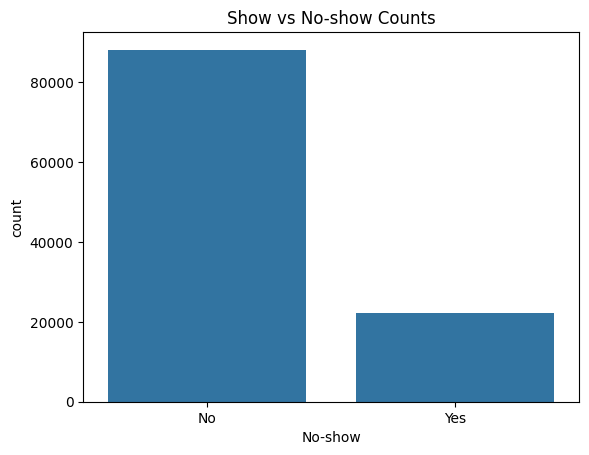

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='No-show')
plt.title("Show vs No-show Counts")
plt.show()

# This data seems to be imbalanced --> don't want to use accuracy alone

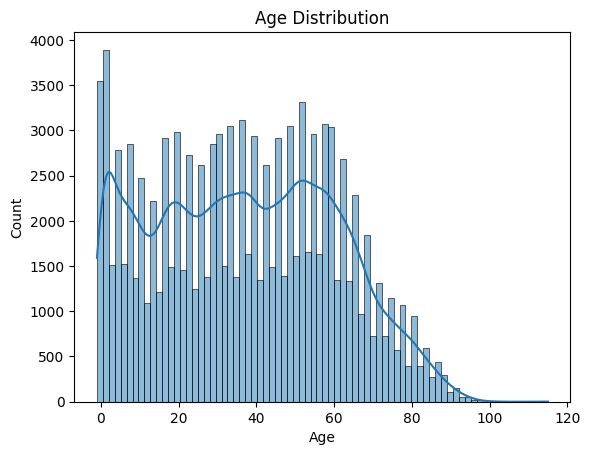

In [42]:
sns.histplot(X['Age'], kde=True)
plt.title("Age Distribution")
plt.show()

<ipython-input-45-fdcf7ef43e5c>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_rate = X_age.groupby('AgeGroup')['No-show'].mean().reset_index()


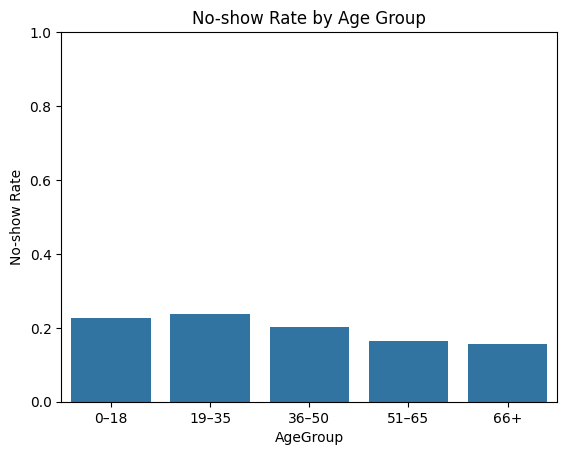

In [45]:
X_age = X.copy()
X_age['No-show'] = y
X_age['AgeGroup'] = pd.cut(X_age['Age'], bins=[0, 18, 35, 50, 65, 100], labels=['0–18', '19–35', '36–50', '51–65', '66+'])

age_rate = X_age.groupby('AgeGroup')['No-show'].mean().reset_index()

sns.barplot(data=age_rate, x='AgeGroup', y='No-show')
plt.ylabel('No-show Rate')
plt.title('No-show Rate by Age Group')
plt.ylim(0, 1)
plt.show()




*   Younger patients are more likely to miss appointments, mostly patient with age from 19 to 35
*   The difference is significant which indicates that age is a strong predictor of missing appointments



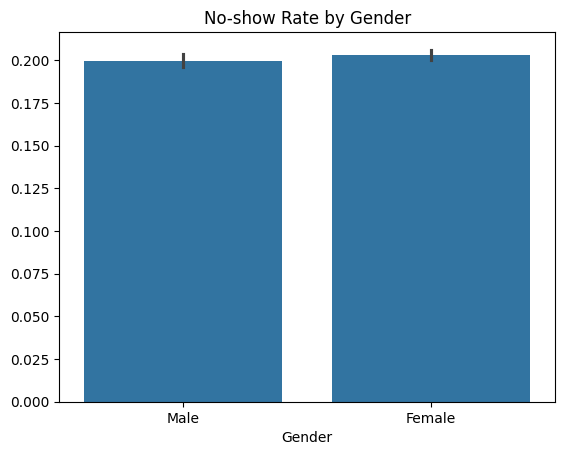

In [43]:
sns.barplot(x=X['Gender'], y=y)
plt.xticks([0,1], ['Male', 'Female'])
plt.title("No-show Rate by Gender")
plt.show()



*   Female and male patients have approximately similar no-show rate, at about 20% (female is slightly higher)
*   The difference between these two is not statistically significant



<ipython-input-47-7174e0275c8b>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_time_rate = X_lead.groupby('LeadTimeGroup')['No-show'].mean().reset_index()


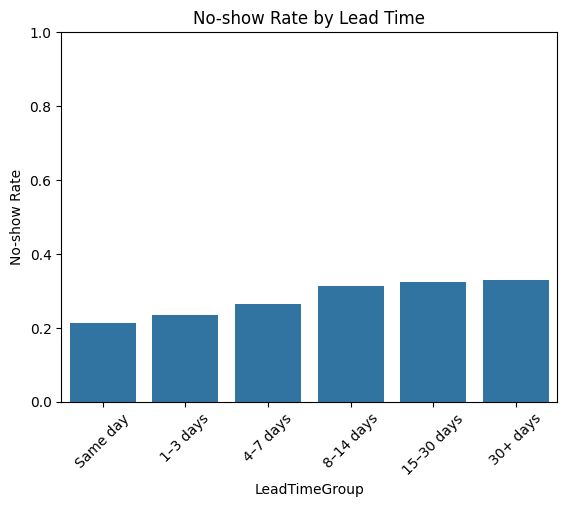

In [47]:
X_lead = X.copy()
X_lead['No-show'] = y
X_lead['LeadTimeGroup'] = pd.cut(X_lead['lead-time'], bins=[-1, 0, 3, 7, 14, 30, 100], labels=['Same day', '1–3 days', '4–7 days', '8–14 days', '15–30 days', '30+ days'])

lead_time_rate = X_lead.groupby('LeadTimeGroup')['No-show'].mean().reset_index()

sns.barplot(data=lead_time_rate, x='LeadTimeGroup', y='No-show')
plt.ylabel('No-show Rate')
plt.title('No-show Rate by Lead Time')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()




*   When lead time is smaller, the rate of missing appointments is lower. This further indicates that the closer the appointment is, the lower the rate of patient missing the appointment.
*   When appointments are scheduled for the same day, the no-show rate is lowest (~21%).
*   As the lead time increases, the no-show rate gradually increases
*   The longer the patient wait or can book their appointment, the more likely they will miss their appointment
*   Leadtime is a significant feature



## **Model Training**

---

Logistic Regression, XGBoost


Why these 2 models?


*   Logistic Regression: simple but insightable -> it is fast and handles large dataset really well which is good for quick baseline and understanding importance of features
*   XGBoost: good for imbalanced and structured data




In [49]:

# Train model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1234)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (LogReg):")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report (LogReg):
              precision    recall  f1-score   support

           0       0.86      0.69      0.77     26491
           1       0.32      0.57      0.41      6668

    accuracy                           0.67     33159
   macro avg       0.59      0.63      0.59     33159
weighted avg       0.75      0.67      0.70     33159

ROC AUC Score: 0.666918323518868


AUC = 0.66 means model is fairly good but still does not capture some complex pattern in the data

In [50]:

# Calculate scale_pos_weight = (negative class / positive class)
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Train model
xgb = XGBClassifier(scale_pos_weight=scale_weight, use_label_encoder=False, eval_metric='logloss', random_state=1234)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:09:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.90      0.57      0.70     26491
           1       0.31      0.76      0.44      6668

    accuracy                           0.61     33159
   macro avg       0.61      0.67      0.57     33159
weighted avg       0.79      0.61      0.65     33159

ROC AUC Score: 0.7316056531247825


XGBoost is significantly better with AUC = 0.73

Interpretation:  if the model randomly picks one no-show and one show patient, XGBoost has a 73.2% chance of correctly ranking the no-show higher in risk.

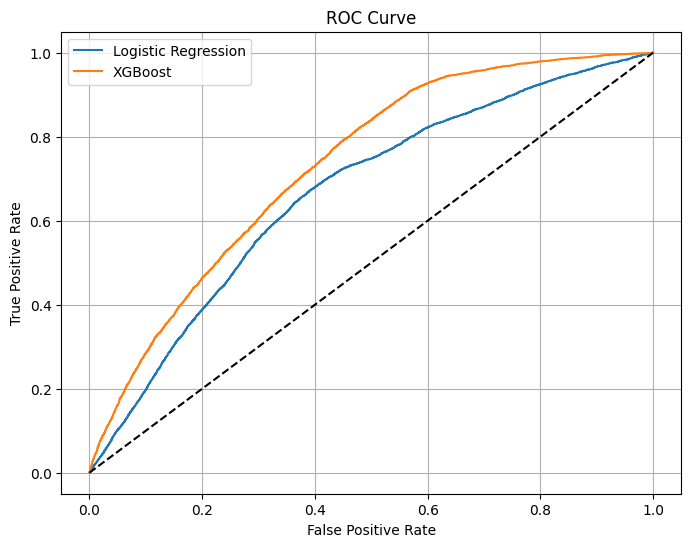

In [51]:


fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


From ROC curve, XGBoost has better predictive power.

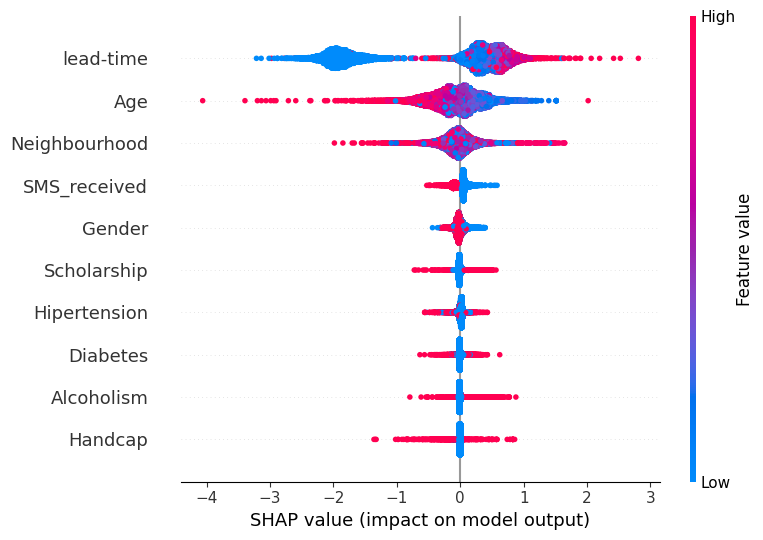

In [53]:
import shap

# Build SHAP explainer
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test)


🔼 Lead time and age are the strongest predictors of no-shows

🔔 Receiving an SMS reminder reduces no-show risk

🏙️ Neighborhood patterns suggest location-based disparities

⚠️ Clinical factors like Hypertension or Diabetes were not strongly predictive, which may surprise some stakeholders

